# Held Suarez test simulations

Held, I.M. and Suarez, M.J., 1994. A proposal for the intercomparison of the dynamical cores of atmospheric general circulation models. Bulletin of the American Meteorological society, 75(10), pp.1825-1830.

In [1]:
import numpy as np
import tensorflow as tf

import TensorDynamics.model_def as md
import TensorDynamics.constants as constants

import matplotlib.pyplot as plt
from scipy.signal import periodogram
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

tf.config.list_physical_devices('GPU')

print("Num GPUs Available: ", (tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Creation of the dynamical model object

Create a model with 20 equidistant vertical sigma levels, truncation 42, and 64 gaussian latitudes

In [2]:

# Define some parameters of the model
nlevels=20 # number of vertical levels
trunc=42 # spectral truncation limit
nlats=64 # number of gaussian latitudes

# create the atmospheric model
int_type="leap"
model=md.model(nlats,trunc,nlevels,int_type=int_type,physics_list=["held_suarez"])

# runtime of 100 days
days=100
runtime=24*days # in units of hours

# create arrays for lats, lons, sigmas for ease of use
lats=model.f_obj.lats
wlats=lats[None,:,None] # wide lats array for broadcasting
lons=model.f_obj.lons
wlons=lons[None,None,:] # wide lons array for broadcasting
sigmas=model.sigmas
wsigmas=model.sigmas[:,None,None] # wide sigmas array for broadcasting

# latitudes in degrees, for plotting
latsDeg=lats*180/np.pi

## Creation of the initial isothermal state at rest, with small perturbations

In [3]:
# some constants
A_EARTH=constants.A_EARTH

# initial wind and temperature fields
u_init=tf.zeros(shape=(nlevels,nlats,nlats*2),dtype=np.single)
v_init=tf.zeros_like(u_init)
T_init=tf.random.uniform((nlevels,nlats,nlats*2),maxval=0.001,dtype=np.single)+300 # add small perturbations to break equilibrium

# surface geopotential
geopot_surface=tf.zeros(shape=(1,nlats,nlats*2),dtype=np.single)

# surface pressure
PS=(tf.ones(shape=(1,len(lats),len(lons)),dtype=np.single)*100000)

# create dictionaries for the steady state initial conditions and the perturbed initial conditions
# set specific humidity to zero
init_state={"surface_pressure":PS,"temperature":T_init,"specific_humidity":T_init*0,
	"u_component_of_wind":u_init,"v_component_of_wind":v_init,"geopotential_at_surface":geopot_surface}

## Integrate Forward from Initial State
First run for 100 days to acclimate to nudging

Then run for 1000 days, saving output every five days

In [4]:

intermediate_state=model.stepper(runtime,init_state)

output_int=120 # hours
final_state,history=model.stepper(runtime*10,intermediate_state,output_interval=output_int)

## Results
### First the mean state and eddy variance
Compare with figures 1-4 of Held and Suarez (1994).



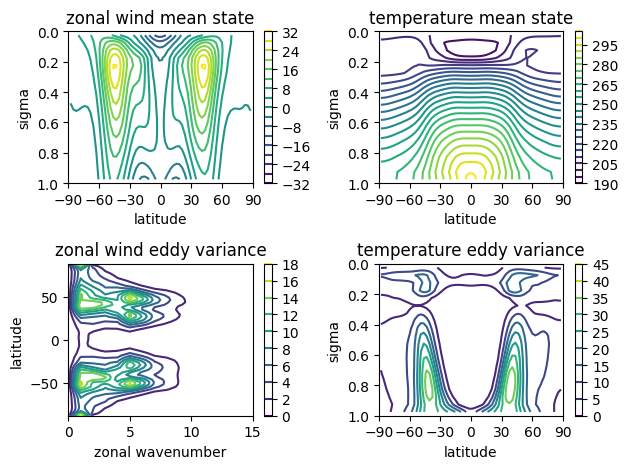

In [5]:
# Calculate mean state from 5-day snapshots
mean_state={}
for vari in ["u_component_of_wind" , "temperature", "v_component_of_wind","surface_pressure","velocity_potential","streamfunction"]:
    mean_state[vari]=np.mean(tf.stack([h[vari] for h in history],axis=0),axis=0)

# calculate eddy variance using anomalies from the mean state
eddy_variance={}
for vari in  ["u_component_of_wind" , "temperature", "v_component_of_wind","surface_pressure"]:
    eddy_variance[vari]=np.mean(tf.stack([(h[vari]-mean_state[vari])**2 for h in history],axis=0),axis=0)

# for eddy variance of U in spectral space, use periodogram
U_eddy_variance=np.mean([(periodogram((h["u_component_of_wind"]-mean_state["u_component_of_wind"]),scaling="spectrum")[1]) for h in history],axis=(0,1))

plt.figure()

# plot model mean zonal wind
plt.subplot(2,2,1)
plt.contour(latsDeg,sigmas,np.mean(mean_state["u_component_of_wind"],axis=-1),levels=np.arange(-32,36,4))
plt.title("zonal wind mean state")
plt.xlabel("latitude")
plt.ylabel("sigma")
plt.xticks(np.arange(-90,91,30))
plt.ylim([1, 0])
plt.colorbar()

# plot model mean temperature
plt.subplot(2,2,2)
plt.title("temperature mean state")
plt.xlabel("latitude")
plt.ylabel("sigma")
plt.contour(latsDeg,sigmas,np.mean(mean_state["temperature"],axis=-1),levels=np.arange(190,306,5))
plt.colorbar()
plt.xticks(np.arange(-90,91,30))
plt.ylim([1, 0])

# plot zonal wind eddy variance
plt.subplot(2,2,3)
plt.contour([m for m in range(np.shape(U_eddy_variance)[1])],latsDeg,U_eddy_variance,levels=np.arange(0,20,2))
plt.xlim([0, 15])
plt.title("zonal wind eddy variance")
plt.colorbar()
plt.xlabel("zonal wavenumber")
plt.ylabel("latitude")
plt.gca().set_aspect("auto")



# plot temperature eddy variance
plt.subplot(2,2,4)
plt.title("temperature eddy variance")
plt.xlabel("latitude")
plt.ylabel("sigma")
plt.contour(latsDeg,sigmas,np.mean(eddy_variance["temperature"],axis=-1),levels=np.arange(0,50,5))
plt.colorbar()
plt.xticks(np.arange(-90,91,30))
plt.ylim([1, 0])

plt.tight_layout()

### Some example snapshots showing internal variability

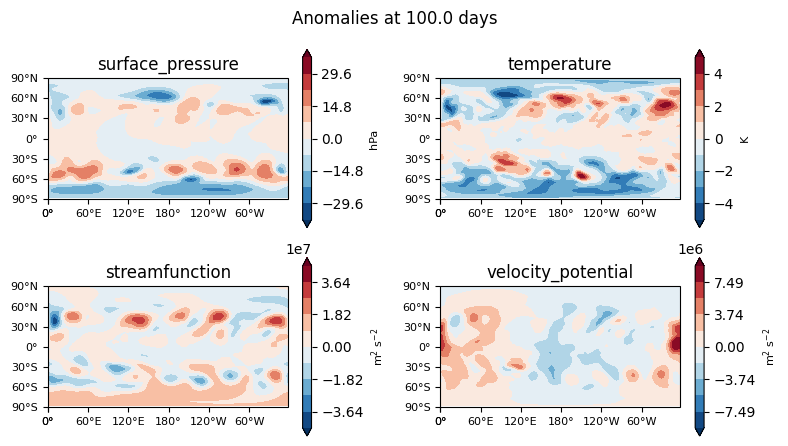

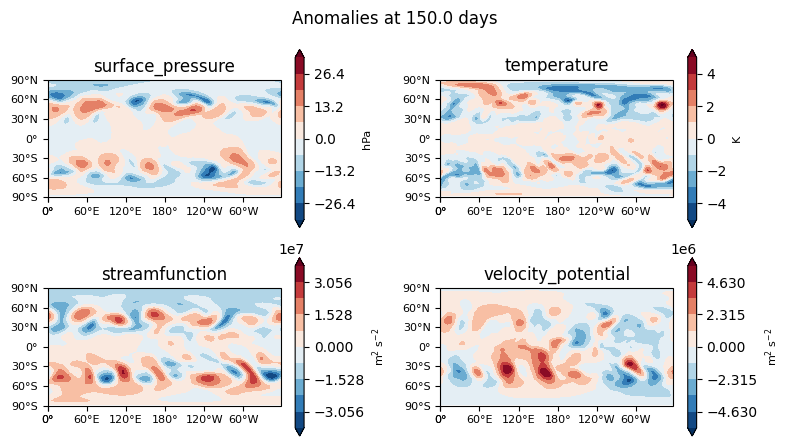

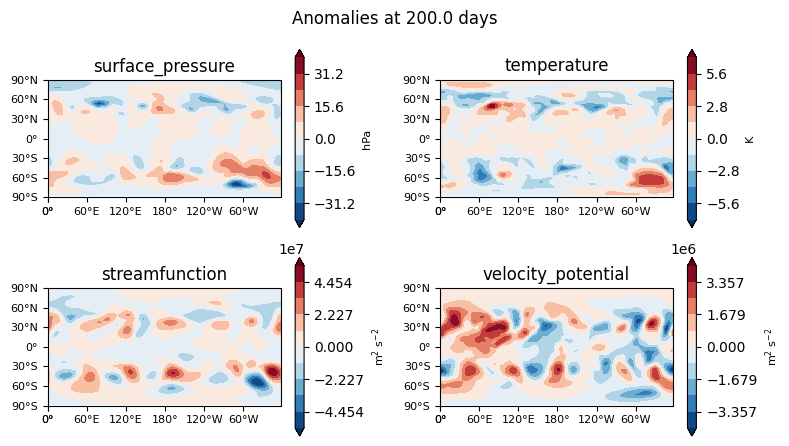

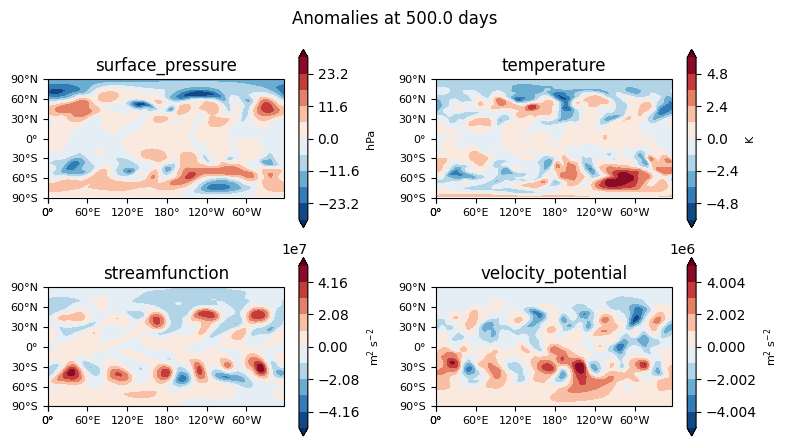

In [6]:
# calculate anomalies from the mean state
anomalies={}
for vari in  ["u_component_of_wind" , "temperature", "v_component_of_wind","surface_pressure","velocity_potential","streamfunction"]:
    anomalies[vari]=[(h[vari]-mean_state[vari]) for h in history]

cl=180
proj = ccrs.PlateCarree(central_longitude=cl)

plot_ind=5

# create plots for surface pressure, temperature, and streamfunction for different lead times
plot_days=[20,30,40,100]
units=["hPa","K",r"m$^2$ s$^{-2}$",r"m$^2$ s$^{-2}$"]
for i,plot_day in enumerate(plot_days):

	
	fig , axes=plt.subplots(nrows=2,ncols=2,figsize=[8,4.5],squeeze=False,subplot_kw=dict(projection=proj))
	
	for j,varname in enumerate(["surface_pressure","temperature","streamfunction","velocity_potential"]):

		# calculate deviation from steady state
		field=anomalies[varname][plot_day]
		if varname=="surface_pressure":
			field=field[0]/100 # convert to hPa
		else:
			field=field[plot_ind]
		
		ax=axes[int(j/2)][j%2]

		mag=np.round(np.nanmax(np.abs(field)))
		if mag==0:
			mag=0.1

		levels=np.linspace(-mag,mag,num=11)

		im=ax.contourf(lons*180/np.pi,lats*180/np.pi,field,levels=levels,transform=ccrs.PlateCarree(),cmap="RdBu_r",extend='both')
		
		ax.set_xticks([0, 60, 120, 180, 240, 300, 360], crs=ccrs.PlateCarree())
		ax.set_yticks([-90,-60,-30, 0, 30, 60, 90], crs=ccrs.PlateCarree())
		ax.set_title(varname)
		lon_formatter = LongitudeFormatter()
		lat_formatter = LatitudeFormatter()
		ax.xaxis.set_major_formatter(lon_formatter)
		ax.yaxis.set_major_formatter(lat_formatter)
		ax.tick_params(labelsize=8)
		ax.set_ylim([-90,90])

		cbar=plt.colorbar(im,orientation="vertical")
		cbar.set_label(label=units[j],size=8)
		
	plt.suptitle("Anomalies at " + str(plot_day*output_int/24)+" days")
	plt.tight_layout(rect=[0,0,1,1])
